# 02 Gaussian Processes
Author: Karan Shah


In [1]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker

import ipywidgets as widgets
from IPython.display import display

np.random.seed(0)

This notebook consists of a tutorial on Gaussian Processes. We assume that students have been exposed to basic probablity concepts. Fill in the `None` values in code blocks beginning with `# Exercise`.

## Gaussian Processes
We begin with a few definitions GPs. They might not make sense for now, but we will deconstruct them and build up the concepts from ideas in probability theory that you are familiar with.

GPs represent a powerful and flexible tool in the realm of machine learning and statistical modeling, especially for tasks involving regression, classification, and optimization. At its core, a GP is a collection of random variables, any finite number of which have a joint Gaussian distribution. This concept allows us to model and infer continuous functions with a level of uncertainty. GPs are non-parametric supervised learning models.

What does this mean?
- Non-parametric: The model does not have parameters that change with the data. Recall that in simple linear regression $y=mx+c$, there is a fixed set of parameters $m$ and $c$ that can be calculated using $x,y$ values. Similarly, neural network training process consists of modifying their weights iteratively to get the prediction closer to the known results. GPs don't have a fixed number of such trainable parameters. The complexity of the model can grow with the data, providing a flexible approach to modeling.
- Supervised: That simply means that we have existing data, a training set consisting of input-output pairs (like $y=f(x)$, $x$ is the input, $y$ is the output), that we consider to be true. We use this to create a model which is then used to make predictions on unknown inputs (say new $x$ values). Simple linear regression, neural networks and GPs are examples of supervised learning methods. 

### Building intuition

We begin with the Univariate Gaussian (aka Normal) distribution, defined by two parameters: the mean ($\mu$), which determines the location of the center of the distribution, and the variance ($\sigma^2$), which determines the spread of the distribution.
We can say that a random variable $X$ follows the distribution
$$ X \sim \mathcal{N}(\mu, \sigma^2) $$

Here, "$\sim$" reads as "is distributed as", "$\mathcal{N}$" denotes the normal distribution, $\mu$ is the mean, and $\sigma^2$ is the variance of the distribution.
The probability density function (PDF) of a Gaussian distribution for a sample $x$ is given by:
$$ p(x|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right) $$
This equation shows how the probability of $x$ decreases as it moves away from $\mu$, adjusted for the distribution's spread, $\sigma^2$. In this notation, this means it is the conditional probability of getting a value $x$ given that we have $\mu$ and $\sigma^2$.

We can sample scalar values, $x_i$ from this distribution.



In [2]:
mu = 1.0
sigma = 0.1
n_samples = 10
samples = np.random.normal(mu, sigma, n_samples)
print(samples)

[1.17640523 1.04001572 1.0978738  1.22408932 1.1867558  0.90227221
 1.09500884 0.98486428 0.98967811 1.04105985]


Note that these are 10 separate scalar samples. Let's us visualize the distribution with a higher numeber of samples:

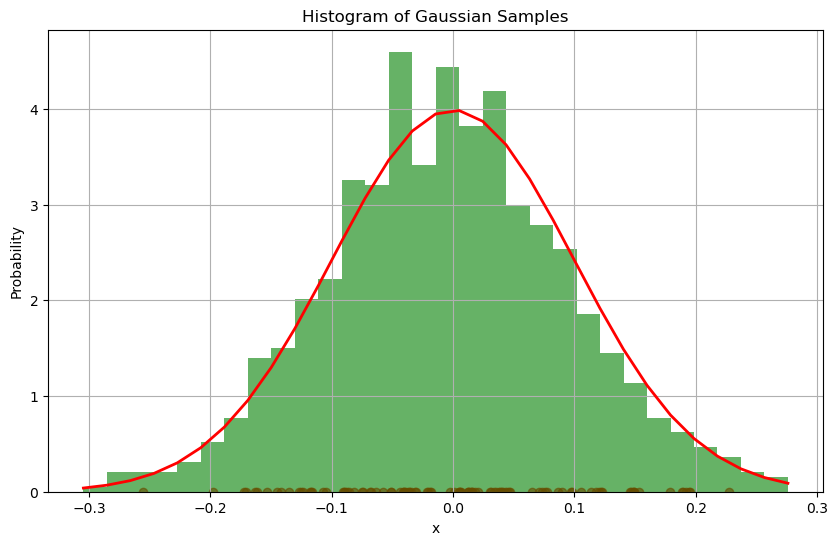

In [3]:
# Utility: Plotting gaussian samples
def plot_gaussian_samples(mu=0, sigma=0.1, fixed_axis=False):
    samples = np.random.normal(mu, sigma, 1000)

    plt.figure(figsize=(10, 6))
    plt.scatter(samples[:100], np.zeros(100), alpha=0.6, color='r')
    count, bins, ignored = plt.hist(samples, 30, density=True, alpha=0.6, color='g')
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu)**2 / (2 * sigma**2)), linewidth=2, color='r')
    if fixed_axis:
        plt.xlim(-10, 10)
    plt.title('Histogram of Gaussian Samples')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

plot_gaussian_samples(mu=0, sigma=0.1, fixed_axis=False)
    

Here red points denote some individual samples. Notice that there are many more samples near the mean and the number of samples decreases as we move away from the mean. The histogram also demonstrates this.

In [4]:
mu_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='Mean (mu):', continuous_update=False)
sigma_slider = widgets.FloatSlider(value=1.0, min=0.1, max=10, step=0.1, description='Std Dev (sigma):', continuous_update=False)

interactive_plot = widgets.interactive(plot_gaussian_samples, mu=mu_slider, sigma=sigma_slider, fixed_axis=True)

display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Mean (mu):', max=5.0, min=-…

Play around with the slider and notice how $\mu$ affects the location of the peak and $\sigma$ affects the spread of the distribution.

#### Adding another dimension 

In the case of the Bivariate Gaussian distribution, we are dealing with two random variables, let's call them $X_a$ and $X_b$. These variables are jointly distributed according to a Gaussian distribution. The distribution is characterized by:

1. Mean Vector ($\boldsymbol{\mu}$): This is a vector of means for the variables, given by $\boldsymbol{\mu} = [\mu_a, \mu_b]^T$, where $\mu_a$ and $\mu_b$ are the means of $X_a$ and $X_b$, respectively.

2. Covariance Matrix ($\Sigma$): This matrix captures the variances of the variables along its diagonal and the covariance between the variables off-diagonal. It is given by:
   $$
   \Sigma = \begin{bmatrix}
   \sigma_a^2 & \rho\sigma_a\sigma_b \\
   \rho\sigma_a\sigma_b & \sigma_b^2
   \end{bmatrix}
   $$
   Here, $\sigma_a^2$ and $\sigma_b^2$ are the variances of $X_a$ and $X_b$, respectively, and $\rho\sigma_a\sigma_b$ is the covariance between $X_a$ and $X_b$. The parameter $\rho$ represents the correlation coefficient between $X_a$ and $X_b$, which measures the linear relationship between the variables.



The probability density function (PDF) of the Bivariate Gaussian distribution for a vector $\mathbf{x} = [x_a, x_b]^T$ is given by:
$$
p(\mathbf{x}|\boldsymbol{\mu}, \Sigma) = \frac{1}{2\pi\sqrt{|\Sigma|}} \exp\left(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)
$$
Here, $|\Sigma|$ denotes the determinant of the covariance matrix $\Sigma$, and $\Sigma^{-1}$ is the inverse of $\Sigma$.



In [5]:
# Utility: Plotting bivariate gaussian samples
def plot_bivariate_gaussian(mu_a=0, mu_b=0, sigma_a=1, sigma_b=1, rho=0, ret_samples=False):
# Function to plot Bivariate Gaussian sampledef plot_bivariate_gaussian(mu_a=0, mu_b=0, sigma_a=1, sigma_b=1, rho=0):
    # Mean vector and covariance matrix
    num_samples = 100

    mu = np.array([mu_a, mu_b])
    sigma = np.array([[sigma_a**2, rho*sigma_a*sigma_b], [rho*sigma_a*sigma_b, sigma_b**2]])
    
    # Create grid and multivariate normal
    x_a = np.linspace(-10, 10, 500)
    x_b = np.linspace(-10, 10, 500)
    X_a, X_b = np.meshgrid(x_a, x_b)
    pos = np.dstack((X_a, X_b))
    rv = multivariate_normal(mu, sigma)
    samples = np.random.multivariate_normal(mu, sigma, num_samples)

    # Make the plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    Z = rv.pdf(pos)
    contour = ax.contourf(X_a, X_b, Z, cmap='viridis', levels=50)
    plt.colorbar(contour, ax=ax)
    ax.scatter(samples[:,0], samples[:,1], color='r', s=10, label='Samples')
    ax.set_xlabel('X_a')
    ax.set_ylabel('X_b')
    ax.set_title('Bivariate Gaussian Distribution')
    plt.show()
    if ret_samples:
        return samples


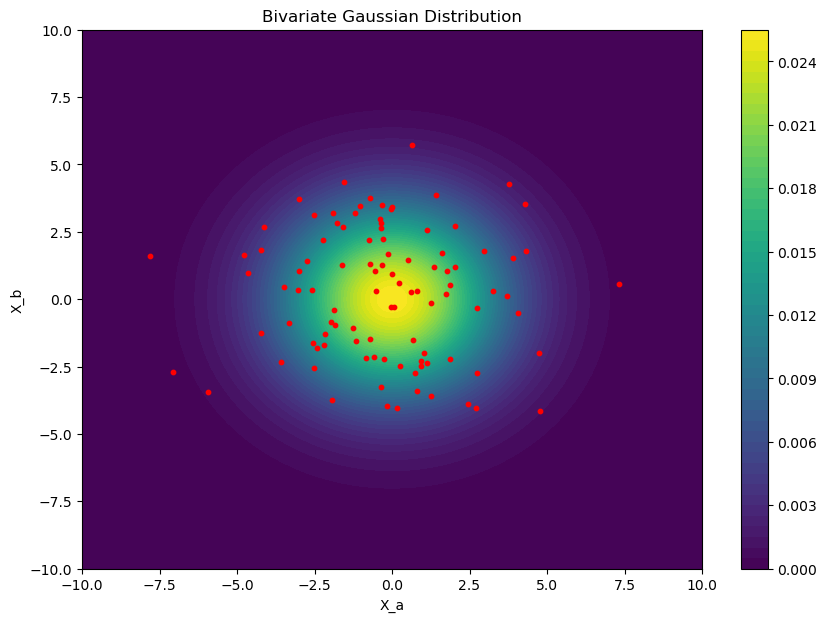

Samples:
[[ 0.92793138 -2.47455637]
 [ 1.60907819  1.72224167]
 [ 0.68661801 -1.50905109]
 [ 1.77214894  1.05704644]
 [-7.79214148  1.61113008]
 [-4.78435668  1.65890394]
 [-0.385181    2.9840292 ]
 [-0.24540303 -2.21653565]
 [-0.36838416  2.64951574]
 [ 0.06561654 -0.2858379 ]]


In [6]:
samples = plot_bivariate_gaussian(mu_a=0, mu_b=0, sigma_a=2.5, sigma_b=2.5, rho=0, ret_samples=True)
print(f"Samples:\n{samples[:10]}")

Notice that the samples are now 2 dimensional vectors. In the plot above, the brightness denotes probability, so brighter regions have more samples than the darker regions.

The covariance matrix is an important factor in determining the density of the distribution:

   $$
   \Sigma = \begin{bmatrix}
   \sigma_X^2 & \rho\sigma_X\sigma_Y \\
   \rho\sigma_X\sigma_Y & \sigma_Y^2
   \end{bmatrix}
   $$
   
- Diagonal Elements: The elements on the diagonal ($\sigma_X^2$, $\sigma_Y^2$) represent the variances of $X$ and $X_b$. A higher variance indicates a wider spread of the distribution along that variable.
- Off-diagonal Elements: The off-diagonal elements ($\rho\sigma_X\sigma_Y$) represent the covariance between $X$ and $X_b$. If $\rho$ is positive, $X$ and $X_b$ tend to increase together, indicating a positive linear relationship. If $\rho$ is negative, one variable tends to increase as the other decreases, indicating a negative linear relationship. If $\rho$ is 0, the variables are uncorrelated.

Keep in mind we can write this as:
   $$
   \Sigma = \begin{bmatrix}
   f(\sigma_X,\sigma_X) & f(\rho,\sigma_X,\sigma_Y) \\
   f(\rho,\sigma_X,\sigma_Y) & f(\rho,\sigma_X,\sigma_Y)
   \end{bmatrix}
   $$
   with a slight abuse of notation. Also note that we can figure out a way to sample from a a random variable $X_b$ if we know the $X$, $\boldsymbol{\mu}$ and $\Sigma$, with the pdf denoted by $p(y|x, \boldsymbol{\mu},\Sigma)$ This structure will repeat soon.

In [7]:
# Widgets for the means
mu_a_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description=r'$\mu_a$:', continuous_update=False)
mu_b_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description=r'$\mu_b$:', continuous_update=False)

# Widgets for the standard deviations
sigma_a_slider = widgets.FloatSlider(value=2.5, min=0.1, max=5, step=0.1, description=r'$\sigma_a$:', continuous_update=False)
sigma_b_slider = widgets.FloatSlider(value=2.5, min=0.1, max=5, step=0.1, description=r'$\sigma_b$:', continuous_update=False)

# Widget for the correlation coefficient
rho_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.01, description=r'$\rho$:', continuous_update=False)

# Display the interactive plot
interactive_plot = widgets.interact(plot_bivariate_gaussian, mu_a=mu_a_slider, mu_b=mu_b_slider, sigma_a=sigma_a_slider, sigma_b=sigma_b_slider, rho=rho_slider, ret_samples=False)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='$\\mu_a$:', max=5.0, min=-5…

Now we can go on to arbitrary dimensions. Here we plot a single vector sample of $n$ dimensions n a 1D plot. We keep the $\Sigma$ matrix diagonal, so there is no correlation between the different points.


In [8]:
def plot_multivariate_sample(n=5):
    mu = np.zeros(n)
    sigma = np.diag(np.ones(n))
    sample = np.random.multivariate_normal(mu, sigma, 1)
    plt.figure(figsize=(10, 2))
    plt.plot(sample[0], 'o')
    plt.title(f'Single Vector Sample from {n}-Dimensional Multivariate Normal Distribution')
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.grid(True)
    plt.xticks(range(n))
    plt.show()

widgets.interact(plot_multivariate_sample, n=widgets.IntSlider(min=1, max=50, step=1, value=5, description='Dimension:'))


interactive(children=(IntSlider(value=5, description='Dimension:', max=50, min=1), Output()), _dom_classes=('w…

<function __main__.plot_multivariate_sample(n=5)>

Since the covariance matrix is diagonal, there is no correlation between the different dimensions. This could be made to look like a function (eg sine curve) by manipulating the covariance values in the $\Sigma$ matrix. 

Now, a function $y=f(x)$ can be thought of as infinite collection of points. What if there was a way to generate functions that could be used to model some phenomenon where we had the function values $y_i$ at certain points $x_i$? We could use it to calculate new $y$ values for corresponding $x$ vaules.


We can also get the conditional distributions. Say we have two sets of random variables $X_a$ and $X_b$. 

Then we have
Assume $\mathbf{x} \sim \mathcal{N}(\mu, \boldsymbol{\Sigma})$ where
$$
\mathbf{x}=\left[\begin{array}{c}
\mathbf{x}_a \\
\mathbf{x}_b
\end{array}\right] \quad \boldsymbol{\mu}=\left[\begin{array}{l}
\boldsymbol{\mu}_a \\
\boldsymbol{\mu}_b
\end{array}\right] \quad \boldsymbol{\Sigma}=\left[\begin{array}{cc}
\boldsymbol{\Sigma}_a & \boldsymbol{\Sigma}_c \\
\boldsymbol{\Sigma}_c^T & \boldsymbol{\Sigma}_b
\end{array}\right]
$$
and 
\begin{aligned}
& p\left(\mathbf{x}_a\right)=\mathcal{N}\left(\boldsymbol{\mu}_a, \boldsymbol{\Sigma}_a\right) \\
& p\left(\mathbf{x}_b\right)=\mathcal{N}\left(\boldsymbol{\mu}_b, \boldsymbol{\Sigma}_b\right)
\end{aligned}

The conditional density of $X_b$ wrt $x_a, \boldsymbol{\mu}_a, \boldsymbol{\mu}_b, \Sigma$ is given by 
$$
p\left(\mathbf{x}_b \mid \mathbf{x}_a\right)=\mathcal{N}\left(\hat{\mu}_b, \hat{\boldsymbol{\Sigma}}_b\right) \quad\left\{\begin{array}{l}
\hat{\boldsymbol{\mu}}_b=\boldsymbol{\mu}_b+\boldsymbol{\Sigma}_c^T \boldsymbol{\Sigma}_a^{-1}\left(\mathbf{x}_a-\boldsymbol{\mu}_a\right) \\
\hat{\boldsymbol{\Sigma}}_b=\boldsymbol{\Sigma}_b-\boldsymbol{\Sigma}_c^T \boldsymbol{\Sigma}_a^{-1} \boldsymbol{\Sigma}_c
\end{array}\right.
$$
We won't derive the above equations here, but you can try it yourself from Chapters 8 and Section 9.1.5 of the Matrix Cookbook (linked in further reading).

What we need to know is that if we have $x_a, x_a, \boldsymbol{\mu}_a, \boldsymbol{\mu}_b, \Sigma$, we can sample $x_b$ conditioned on them.

### Enter Gaussian Processes

A Gaussian Process (GP) extends the idea of a Gaussian distribution over finite sets of variables to functions. A GP is fully specified by its mean function $m(x)$, which gives the average output for each input, and its covariance function $k(x, x')$, which measures how much two inputs, $x$ and $x'$, are correlated. The choice of the kernel function $k$ determines the properties of the functions drawn from the GP, such as smoothness and periodicity.

The formal definition of a Gaussian Process is:
$$ f(x) \sim \mathcal{GP}(m(x), k(x, x')) $$
where
- $m(x)$ is the mean function, typically assumed to be zero for simplicity, i.e., $m(x) = 0$.
- $k(x, x')$ is the covariance function or kernel, defining the covariance between any two points $x$ and $x'$ in the input space.

We have a training set consisting of $n$ inputs $X$ and known outputs $\mathbf{f}$, and we want to estimate the outputs $\mathbf{f}_{*}$ at $n_*$ inputs $X_{*}$.

The joint probability distribution for the observed(training) target values $\mathbf{f}$ at training locations $X$ and predicted(test) target values $\mathbf{f}_{*}$ at test locations $X_*$ is:
$$
\left[\begin{array}{l}
\mathbf{f} \\
\mathbf{f}_{*}
\end{array}\right] \sim \mathcal{N}\left(\mathbf{0},\left[\begin{array}{cc}
K(X, X)+\sigma_{n}^{2} I & K\left(X, X_{*}\right) \\
K\left(X_{*}, X\right) & K\left(X_{*}, X_{*}\right)
\end{array}\right]\right)
$$
Where $K_{P,Q}$ consists of $k(x_p,x_q)$, which is the covariance between two points $x_p$ and $x_q$. The choice of the kernel function $k$ is an important design decision. $K(X,X)$ is a matrix of size $n \times n$, $K(X,X_*)$ is of size $n \times n_*$ and so on.

We generate predictions by sampling from the conditional distribution:
$$\begin{aligned}
\mathbf{f}_{*} | X, \mathbf{f}, X_{*} & \sim \mathcal{N}\left(\overline{\mathbf{f}}_{*}, \left(\mathbf{f}_{*}\right)\right)\operatorname{cov}, \text { where } \\
\overline{\mathbf{f}}_{*} &=K\left(X_{*}, X\right)\left[K(X, X)+\sigma_{n}^{2} I\right]^{-1} \mathbf{f} \\
\operatorname{cov}\left(\mathbf{f}_{*}\right) &=K\left(X_{*}, X_{*}\right)-K\left(X_{*}, X\right)\left[K(X, X)+\sigma_{n}^{2} I\right]^{-1} K\left(X, X_{*}\right)
\end{aligned}$$

Here $\overline{\mathbf{f}}_{*}$ is the mean of the predictions corresponding to inputs $X_{*}$.


Let's implement it using the above formula. Our goal is to get $\overline{\mathbf{f}}_{*}, \operatorname{cov}\left(\mathbf{f}_{*}\right) $. We assume we have some kernel function `kernel(X_1, X_2)` which returns the matrix $K(X_1, X_2)$. We will use built in inversion method `np.linalg.inv` to invert matrices.

In [9]:
# Utility: Easy to understand kernel function implementation
def kernel_matrix(X1, X2, kernel, params):
    return np.array([[kernel(x1, x2, params) for x2 in X2] for x1 in X1])

In [10]:
# Exercise: Setup GPs
def GP(X_train, f_train, X_pred, kernel, params):
    
    # Fill in the Nones
    K = kernel_matrix(None, None, kernel, params) # K(X,X)
    K_ss = kernel_matrix(None, None, kernel, params) # K(X_*,X_*)
    K_s = kernel_matrix(None, None, kernel, params) # K(X,X_*)

    K_inv = np.linalg.inv(K)

    # You can use .T for transpose, and A.dot(B) for dot product. K(X_*, X) is K_s.T

    mu_f_s = None
    cov_f_s = None
    
    return mu_f_s, cov_f_s

## Kernel Playground
Now that we have set up the framework in place, let's see how different kernels behave: 

#

In [11]:
# Utility: Visualize kernels and samples
def visualize_kernels(kernel, params, n_grid=100, n_samples=5):
    
    x = np.linspace(-5, 5, n_grid)
    
    K = kernel_matrix(x, x, kernel, params)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))  # 1 row, 2 columns
    
    cax1 = ax[0].matshow(K, cmap='viridis')
    fig.colorbar(cax1, ax=ax[0])

    ax[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    
    tick_positions = np.linspace(0, len(x)-1, 5, dtype=int) 
    ax[0].set_xticks(tick_positions)
    ax[0].set_xticklabels(np.round(x[tick_positions], 2))
    ax[0].set_yticks(tick_positions)
    ax[0].set_yticklabels(np.round(x[tick_positions], 2))
    
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_title('Kernel Matrix')
    
    
    mu = np.zeros_like(x)
    samples = np.random.multivariate_normal(mu, K, n_samples)

    ax[1].plot(x, mu, 'k--', label='Mean', linewidth=2)
    ax[1].plot(x, samples.T, label='Samples')
    ax[1].set_title('Samples from Kernel')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('f(x)')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

For each kernel, implement the kernel function using the formula given. Then play around with the interactive widgets to get a feel for how the different kernel parameters behave.



#### Exponential Kernel
The exponential covariace function is defined as:
$$
k_{\mathrm{E}}\left(x_1, x_2\right)=\sigma^2 \exp \left(-\frac{|x_1 - x_2|}{2 \ell^{2}}\right)
$$



In [12]:
# Exercise: Implement exponential kernel
def exp_kernel(x1, x2, params = (1.0, 1.0)):
    length_scale, sigma_f = params
    dist = None
    k = None
    return k


The covariance matrix and drawn samples are plotted here:

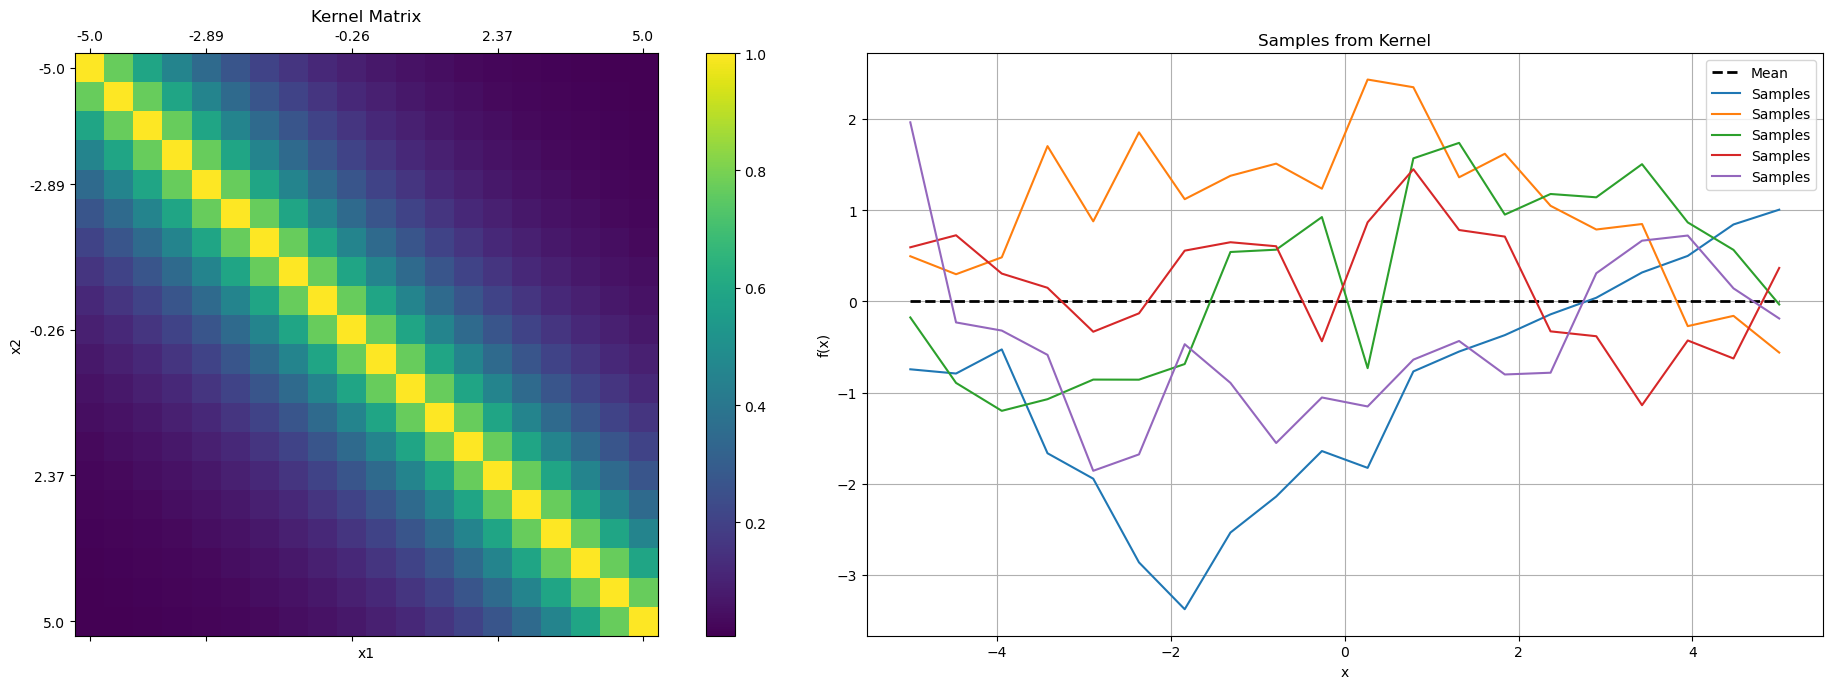

In [13]:
visualize_kernels(exp_kernel, (1.0, 1.0), n_grid=20, n_samples=5)

In [14]:
n_grid_slider = widgets.IntSlider(value=100, min=10, max=200, step=10, description='Test Points:', continuous_update=False)
length_scale_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Length Scale:', continuous_update=False)
sigma_f_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Sigma_f:', continuous_update=False)
n_samples_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Samples:', continuous_update=False)

def GP_wrapper(n_grid, kernel, length_scale, sigma_f, n_samples):
    params = (length_scale, sigma_f)
    visualize_kernels(kernel, params, n_grid=n_grid, n_samples=n_samples)

interactive_plot = widgets.interactive(GP_wrapper, n_grid=n_grid_slider, kernel=widgets.fixed(exp_kernel), length_scale=length_scale_slider, sigma_f=sigma_f_slider, n_samples=n_samples_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(IntSlider(value=100, continuous_update=False, description='Test Points:', max=200, min=1…

Notice how the kernel matrix and the samples change as you adjust the length scale and sigma_f parameters. The length scale parameter controls the smoothness of the function, while the sigma_f parameter controls the vertical variation of the function. You can also adjust the number of test points and the number of samples to see how the function behaves as you increase the resolution of your grid.



#### Squared Exponential Kernel
The squared exponential covariace function is defined as:
$$
k_{\mathrm{SE}}\left(x_1, x_2\right)=\sigma^2 \exp \left(-\frac{|x_1 - x_2|^2}{2 \ell^{2}}\right)
$$

This is the default kernel for most GP models because of its simplicity and versatility. The length parameter $\ell$ controls the width of the wiggles in your function. This creates smoother samples than the exponential kernel.

In [15]:
# Exercise: Implement squared exponential kernel
def sqr_exp_kernel(x1, x2, params = (1.0, 1.0)):
    length_scale, sigma_f = params
    dist = None
    k = None
    return k


The covariance matrix and drawn samples are plotted here:

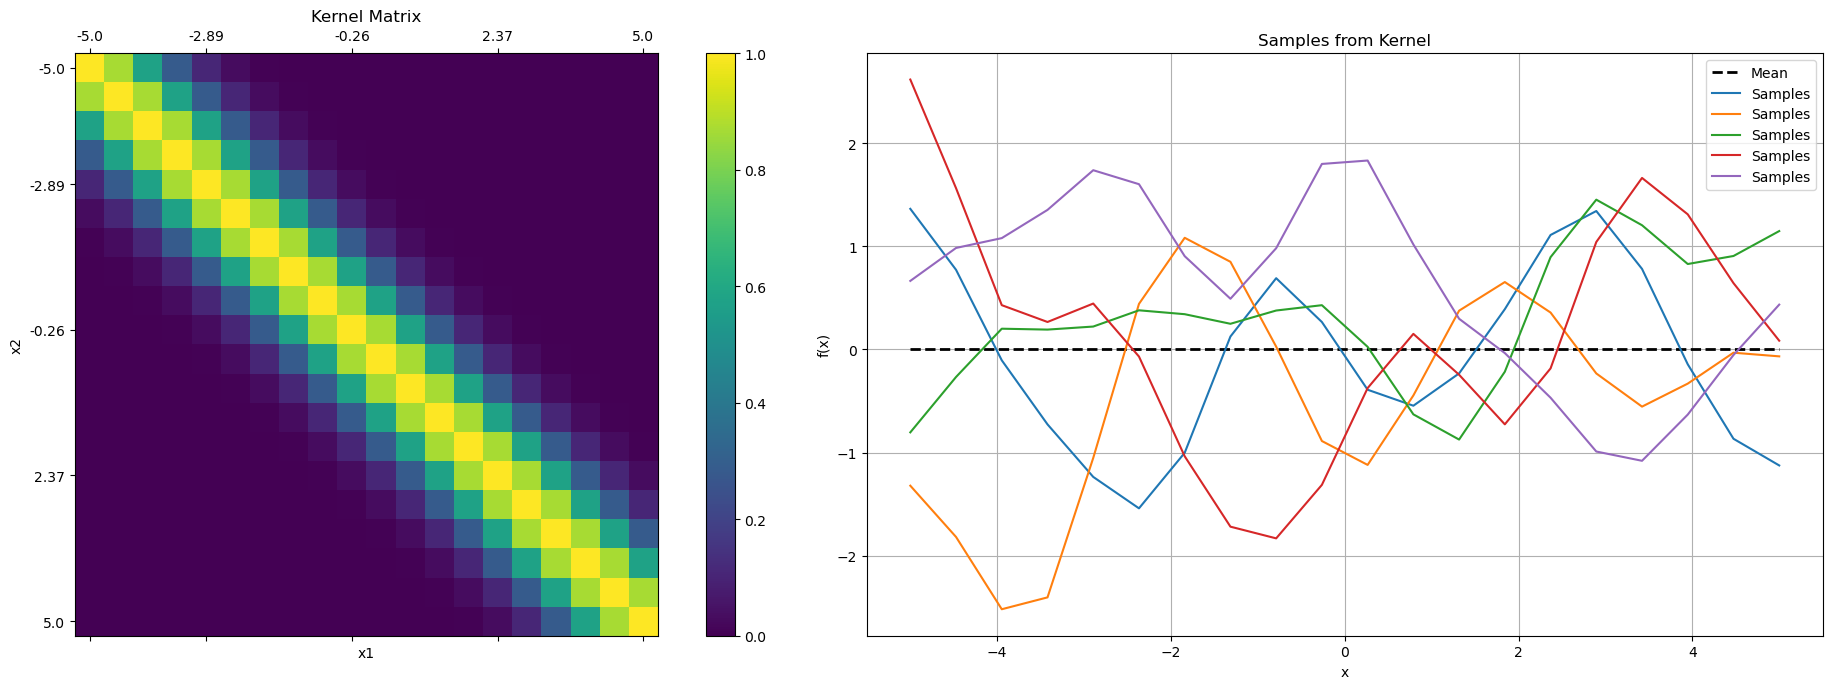

In [16]:
visualize_kernels(sqr_exp_kernel, (1.0, 1.0), n_grid=20, n_samples=5)

In [17]:
n_grid_slider = widgets.IntSlider(value=100, min=10, max=200, step=10, description='Test Points:', continuous_update=False)
length_scale_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Length Scale:', continuous_update=False)
sigma_f_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Sigma_f:', continuous_update=False)
n_samples_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Samples:', continuous_update=False)

def GP_wrapper(n_grid, kernel, length_scale, sigma_f, n_samples):
    params = (length_scale, sigma_f)
    visualize_kernels(kernel, params, n_grid=n_grid, n_samples=n_samples)

interactive_plot = widgets.interactive(GP_wrapper, n_grid=n_grid_slider, kernel=widgets.fixed(sqr_exp_kernel), length_scale=length_scale_slider, sigma_f=sigma_f_slider, n_samples=n_samples_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(IntSlider(value=100, continuous_update=False, description='Test Points:', max=200, min=1…

Looking at the samples, you can see why this is the default kernel. It creates smooth samples which can be used to approximate other smooth functions.



#### Periodic Kernel
The periodic covariace function is defined as:
$$
k_{\mathrm{PER}}\left(x_1, x_2\right)=\sigma^2 \exp \left(-\frac{2\sin^2(\pi|x_1 - x_2|/p)}{\ell^{2}}\right)
$$

As they name suggests, samples drawn from this kernel have a repeating wave-like structure.

In [18]:
# Exercise: Implement periodic kernel
def per_kernel(x1, x2, params = (1.0, 1.0, 1.0)):
    length_scale, sigma_f, period = params
    dist = None
    k = None
    return k

The covariance matrix and drawn samples are plotted here:

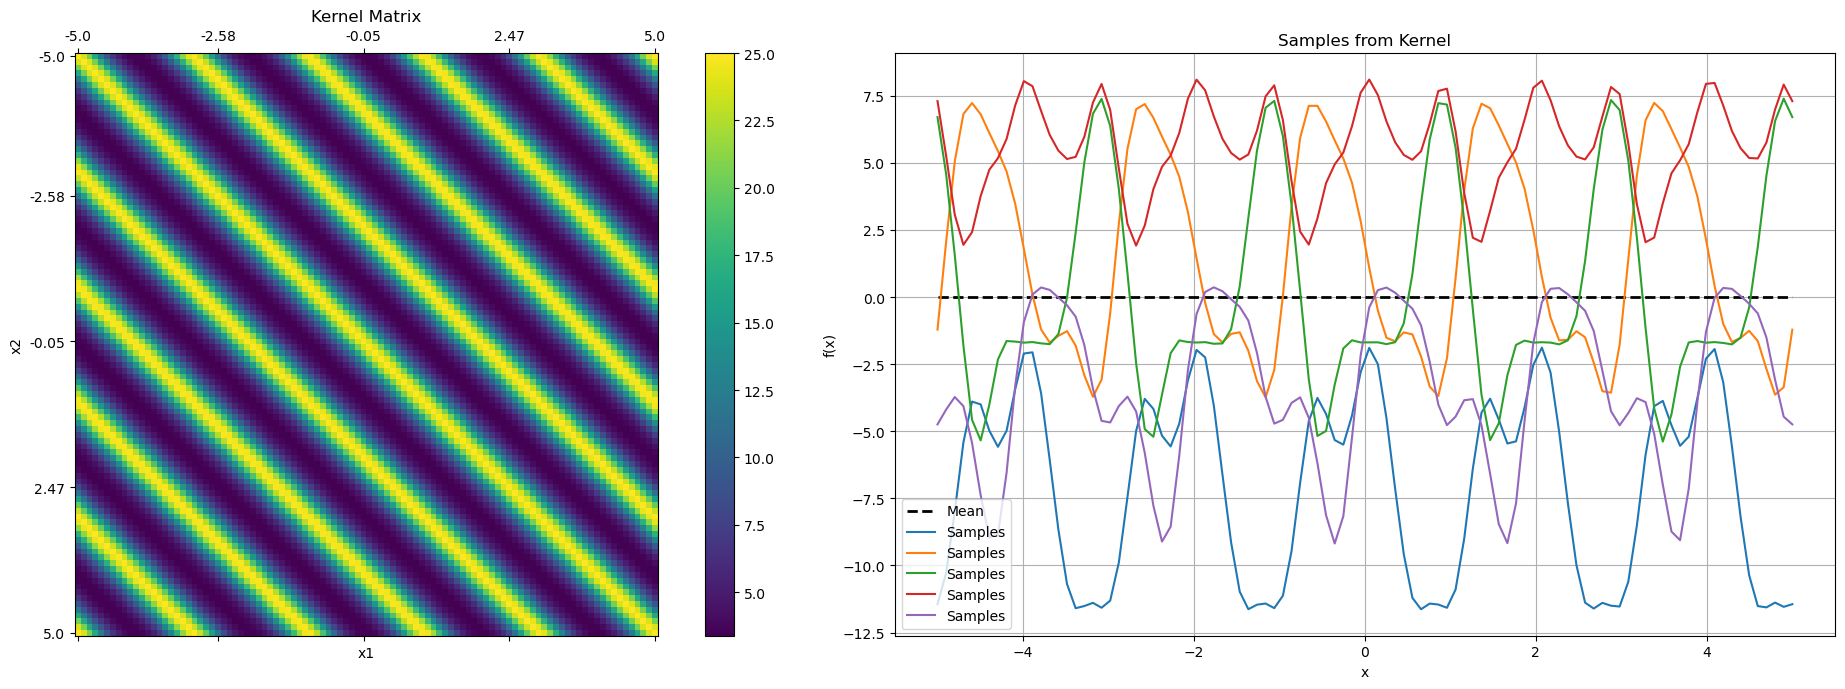

In [19]:
visualize_kernels(per_kernel, (1.0, 5.0, 2.0), n_grid=100, n_samples=5)

In [20]:
n_grid_slider = widgets.IntSlider(value=100, min=10, max=200, step=10, description='Test Points:', continuous_update=False)
length_scale_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Length Scale:', continuous_update=False)
sigma_f_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Sigma_f:', continuous_update=False)
p_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Period:', continuous_update=False)
n_samples_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Samples:', continuous_update=False)

def GP_wrapper(n_grid, kernel, length_scale, sigma_f, period, n_samples):
    params = (length_scale, sigma_f, period)
    visualize_kernels(kernel, params, n_grid=n_grid, n_samples=n_samples)

interactive_plot = widgets.interactive(GP_wrapper, n_grid=n_grid_slider, kernel=widgets.fixed(per_kernel), length_scale=length_scale_slider, sigma_f=sigma_f_slider, period=p_slider, n_samples=n_samples_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(IntSlider(value=100, continuous_update=False, description='Test Points:', max=200, min=1…

Notice how decreasing the period leads to higher frequency samples. Length scale controls the width of the waves while sigma_f controls the amplitude.

### Regression

Let's do a regression task. We will create a synthetic training set, where points follow the the sine function.
$$ f(x) = \sin(x) $$

Then we will use GPs to learn this and draw samples from the resultant distribution. The test set consists of $x$ values where we want to know the value of $f(x)$.

In [21]:
# Utility: Plotting GP regression
def GP_regression_sin(n_train, n_test, kernel, params, uniform_grid=False, plot_samples=False):
    if uniform_grid:
        n_total = n_train + n_test
        X_total = np.linspace(0, 2 * np.pi, n_total)
        step_size = n_total // n_train
        X_train = X_total[::step_size][:n_train]
        mask = np.ones(n_total, dtype=bool)
        mask[::step_size][:n_train] = False
        X_pred = X_total[mask]
        n_test = len(X_pred)
    else:
        X_train = np.random.rand(n_train) * 2 * np.pi
        X_pred = np.random.rand(n_test) * 2 * np.pi
    
    f_train = np.sin(X_train)

    X_pred = np.linspace(0, 2 * np.pi, n_test)


    mu_f_s, cov_f_s = GP(X_train, f_train, X_pred, kernel, params)

    
    samples = np.random.multivariate_normal(mu_f_s, cov_f_s, 3)

    true_x_grid = np.linspace(0, 2 * np.pi, 100)
    true_f = np.sin(true_x_grid)

    plt.figure()
    plt.scatter(X_train, f_train, c='red', label='Training points')
    plt.plot(X_pred, mu_f_s, '-o', lw=2, label='Mean prediction')

    std_dev = np.sqrt(np.abs(np.diag(cov_f_s)))
    plt.fill_between(X_pred, mu_f_s - 2*std_dev, mu_f_s + 2*std_dev, color='gray', alpha=0.2, label='Uncertainty (±2 std dev)')
    
    if plot_samples:
        for i in range(samples.shape[0]):
            plt.plot(X_pred, samples[i], '--', lw=1)

    plt.plot(true_x_grid, true_f, 'k', linestyle=':', label='True sin(x)')
    plt.xlabel('X')
    plt.ylabel('f(X)')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

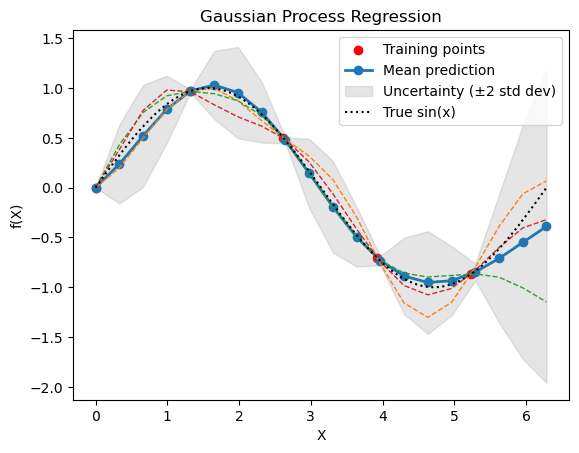

In [22]:
GP_regression_sin(5, 20, sqr_exp_kernel, (1.0, 1.0), uniform_grid=True, plot_samples=True)

Here the red points show the training points, where we already know the true $f(x)$ values. The blue dots are where we evaluate the test points. The colourful dashed lines are samples drawn from this distribution. The gray area shows the uncertainty of prediction at that point. Notice how the uncertainty increases the farther we are from training points, and disappears at training points.

Now use the following widget and see how different kernels behave for this learning task. 
- Vary the training and test data sizes to get a feel for how much training data is enough. 
- In the above plot, the training data was evenly spaced, providing a nice approximation. Now we will have training data at random values, leading to non-uniform uncertainties at different regions.
- Check different kernels and kernel parameter values.
- What kernel serves the best for this learning task? Why? 

In [23]:
n_train_slider = widgets.IntSlider(value=5, min=1, max=100, step=1, description='Training Points:', continuous_update=False)
n_test_slider = widgets.IntSlider(value=10, min=1, max=100, step=1, description='Test Points:', continuous_update=False)
length_scale_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Length Scale:', continuous_update=False)
sigma_f_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2, step=0.1, description='Sigma_f:', continuous_update=False)
plot_samples_checkbox = widgets.Checkbox(value=False, description='Plot Samples')
kernel_selector = widgets.Dropdown(options=['Exponential', 'Squared Exponential', 'Periodic'], value='Squared Exponential', description='Kernel:')
period_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='Period:', continuous_update=False, style={'visibility': 'hidden'})

def update_ui(*args):
    if kernel_selector.value == 'Periodic':
        period_slider.style.visibility = 'visible'
    else:
        period_slider.style.visibility = 'hidden'

kernel_selector.observe(update_ui, 'value')

update_ui()

def GP_wrapper(n_train, n_test, kernel_type, length_scale, sigma_f, period, plot_samples=False):

    if kernel_type == 'Periodic':
        params = (length_scale, sigma_f, period)
        kernel = per_kernel
    elif kernel_type == 'Exponential':
        params = (length_scale, sigma_f)
        kernel = exp_kernel
    elif kernel_type == 'Squared Exponential':
        params = (length_scale, sigma_f)
        kernel = sqr_exp_kernel
    
    GP_regression_sin(n_train, n_test, kernel, params, uniform_grid=False, plot_samples=plot_samples)

interactive_plot = widgets.interactive(GP_wrapper, n_train=n_train_slider, n_test=n_test_slider, kernel_type=kernel_selector, length_scale=length_scale_slider, sigma_f=sigma_f_slider, period=period_slider, plot_samples=plot_samples_checkbox)

display(interactive_plot)

interactive(children=(IntSlider(value=5, continuous_update=False, description='Training Points:', min=1), IntS…

Some values of training and test dataset sizes might lead to very discontinous plots. You can mitigate this by adjusting the kernel parameters.

## Conclusion
In this notebook, we started with Gaussian distributions and built up to Gaussian Processes. We saw how to implement a simple Gaussian Process framework. Then we looked at various kernels and how they behave when varying kernel parameters. Finally we used it for a simple regression task.

In the next notebook, we will look at some sophisticated kernels (that are equivalent to neural networks under certain limits) and then use Gaussian Processes to predict ground state energies for various model quantum systems we studied in notebook 1.

Further reading:
- Gaussian Processes for Machine Learning (main textbook): http://gaussianprocess.org/gpml/
- A Visual Exploration of Gaussian Processes (Interactive Gaussian Process Explainer): https://distill.pub/2019/visual-exploration-gaussian-processes/
- Matrix Cookbook (helpful with Gaussian distribution properties, covariance matrices): https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf

